# **The Project Objective**

The goal of this project is to help new Airbnb hosts estimate a reasonable nightly rental price for their property based on listing characteristics. Using historical data from Airbnb listings, we built predictive models that consider factors such as location (*latitude*, *longitude*, and *neighborhood*), *room type*, *instant book-ability*, *cancellation policy*, and *construction year* to forecast the most suitable rental price for new listings. The analysis includes descriptive, diagnostic and predictive analytics to provide actionable insights for hosts.


**The Dataset:** The dataset used in this project is sourced from Kaggle: [Airbnb Open Data](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata/dataLinks)

**The Data Dictionary:** The data dictionary is available at: [Data Dictionary](https://docs.google.com/spreadsheets/d/1b_dvmyhb_kAJhUmv81rAxl4KcXn0Pymz)


### **Key Analysis**

1. **Data Cleaning**: The code performs comprehensive data cleaning, including:

*   Dropping irrelevant columns (e.g., *name*, *host_id*, *host_name*).
*   Imputing missing values.
*   Removing duplicates.
*   Identifying and removing outliers.
*   Standardizing data types.
*   Deriving new columns, such as *grouped_construction_ years*.


2. **Descriptive Analytics**:

*   Summary statistics, including `mean`, `median`, and `standard deviation`, are calculated to understand the dataset's distribution.
*   Visualization techniques, such as frequency `histograms` and `box plots`, reveal patterns in pricing by *room type*, *neighborhood group*, and *construction year*.

3. **Diagnostic Analytics**:

*   Correlation analysis identifies key drivers for property pricing, with *service fee* emerging as the strongest predictor variable.

*   Cross-tabulations and regression analyses explores the relationships between *price* and categorical variables such as *room type*, *neighborhood group*, and *cancellation policy*.

4. **Predictive Analytics**:

*   Machine learning models are built, including Gradient Boosting Regressor, Linear Regression, K-Nearest Neighbors Regressor, Decision Tree Regressor, and Neural Network, to predict nightly rental prices based on historical data.

*   Each model offers unique insights into pricing determinants, balancing accuracy and interpretability.


### **Practical Use Case:**

The results of this project provide a practical application for Airbnb hosts. By entering details such as location, room type, availability, and cancellation policy, hosts can obtain a suggested nightly rental price. This ensures competitive pricing that aligns with similar listings in the market, helping hosts attract bookings while maximizing revenue.


### **Feasibility:**

The project was executed using Python and leverages the following libraries for analysis, modeling, and visualization:

*   **pandas**: For data manipulation and cleaning.
*   **scikit-learn**: For machine learning and model evaluation.
*   **TensorFlow**: For neural network construction and training.
*   **matplotlib/seaborn**: For visualizing data trends and patterns.

By integrating these tools, the project not only delivers pricing recommendations but also uncovers actionable insights into the market dynamics influencing Airbnb listings.

### **Workflow Structure**

The analysis builds sequentially across four main steps, as detailed in Sections 1–4:

1.   **Data Cleaning**: Ensures a high-quality dataset for analysis.
2.   **Descriptive Analytics**: Summarizes and visualizes patterns.
3.   **Diagnostic Analytics**: Identifies key pricing drivers.
4.   **Predictive Analytics**: Develops and evaluates pricing models.

This structured approach ensures a comprehensive understanding of the dataset and delivers robust pricing insights for new Airbnb hosts.


In [ ]:
# Import the 'drive' module from the 'google.colab' package to enable Google Drive integration.
# Then, mount Google Drive to the '/drive' directory within the Colab environment.
# The 'force_remount=True' parameter ensures that the Drive is remounted even if it was previously mounted.

from google.colab import drive
drive.mount('/drive', force_remount=True)

# Change the current working directory to the specified folder within Google Drive,
# where you can save and load your Colab notebooks or files.
%cd '/drive/MyDrive/Colab Notebooks/INF1340/group project/'

Mounted at /drive
/drive/MyDrive/Colab Notebooks/INF1340/group project


# **Functions and Packages**

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression

################################### Data Cleanning Start ###################################
def read_csv(uri: str) -> pd.DataFrame:
  """Read a CSV file from the given URI and return a pandas DataFrame.

  Args:
    uri: The URI of the CSV file to read.

  Returns:
    A pandas DataFrame containing the data from the CSV file.
  """

  try:
    return pd.read_csv(uri)
  except FileNotFoundError as ex:
    print(f'Error! File Not Found! uri={uri}')
    raise ex

def columns_snakecase(dataFrame: pd.DataFrame) -> None:
  """
  Convert column names in a pandas DataFrame to lowercase and
  replace all spaces with underscores e.g. 'My Column Name' becomes 'my_column_name'.

  Args:
    dataFrame: The pandas DataFrame whose column names need to be converted.
  """

  dataFrame.columns = dataFrame.columns.str.lower().str.replace(' ', '_')

def columns_drop(dataFrame: pd.DataFrame, columns: list) -> None:
  """Drop the specified columns from a pandas DataFrame.

  Args:
    dataFrame: The pandas DataFrame from which columns need to be dropped.
    columns: A list of column names to be dropped from the DataFrame.
  """
  dataFrame.drop(columns, axis=1, inplace=True)

def columns_drop_by_null_percentage(dataFrame: pd.DataFrame, percentage_threshold: float) -> None:
  """
  Drops columns from a DataFrame where the percentage of null values exceeds a given threshold.

  Args:
      dataFrame (pd.DataFrame): The input DataFrame.
      percentage_threshold (float): The threshold for the percentage of null values. Columns with a higher percentage of nulls will be dropped.
  """
  columns = dataFrame.columns[dataFrame.isnull().mean() > percentage_threshold]
  print(f"Droping: {columns}")
  columns_drop(dataFrame, columns)

def columns_fill_null(dataFrame: pd.DataFrame, columns: list, value: any) -> None:
  """
  Fill missing values in the specified columns of a pandas DataFrame with a given value.

  Args:
    dataFrame: The pandas DataFrame in which missing values need to be filled.
    columns: A list of column names whose missing values need to be filled.
    value: The value to fill missing values with.
  """

  for column in columns:
    dataFrame[column].fillna(value, inplace=True)

def columns_dollarize(dataFrame: pd.DataFrame, columns: list) -> None:
  """
  Convert values in the specified columns of a pandas DataFrame from string to float
  by removing dollar signs and commas.

  Args:
    dataFrame: The pandas DataFrame in which values need to be converted.
    columns: A list of column names whose values need to be converted.
  """

  for column in columns:
    dataFrame[column] = dataFrame[column].replace('[\$,]', '', regex=True).astype(float)

def rows_drop_by_condition(dataFrame: pd.DataFrame, condition: any) -> None:
  """
  Drop rows from a pandas DataFrame based on a given condition.

  Args:
    dataFrame: The pandas DataFrame from which rows need to be dropped.
    condition: A pandas DataFrame condition to filter rows.
  """

  dataFrame.drop(dataFrame[condition].index, inplace=True)

def rows_drop_by_null(dataFrame: pd.DataFrame, columns: list) -> None:
  """
  Drop rows from a pandas DataFrame that contain missing values in the specified columns.

  Args:
    dataFrame: The pandas DataFrame from which rows need to be dropped.
    columns: A list of column names whose rows need to be dropped.
  """
  dataFrame.dropna(subset=columns, inplace=True)

def columns_lowercase(dataFrame: pd.DataFrame, columns: list) -> None:
  """
  Convert column names in a pandas DataFrame to lowercase.

  Args:
    dataFrame: The pandas DataFrame whose columns need to be converted.
    columns: A list of column names to be converted to categorical data type.
  """

  for column in columns:
    dataFrame[column] = dataFrame[column].str.lower()

def columns_categorize(dataFrame: pd.DataFrame, columns: list) -> None:
  """
  Convert the specified columns of a pandas DataFrame to categorical data type.

  Args:
    dataFrame: The pandas DataFrame whose columns need to be converted.
    columns: A list of column names to be converted to categorical data type.
  """

  for column in columns:
    dataFrame[column] = dataFrame[column].astype('category')

def columns_boolize(dataFrame: pd.DataFrame, columns: list) -> None:
  """
  Convert the specified columns of a pandas DataFrame to boolean data type.

  Args:
    dataFrame: The pandas DataFrame whose columns need to be converted.
    columns: A list of column names to be converted to boolean data type.
  """

  for column in columns:
    dataFrame[column] = dataFrame[column].astype(bool)

def columns_intize(dataFrame: pd.DataFrame, columns: list) -> None:
  """
  Convert the specified columns of a pandas DataFrame to integer data type.

  Args:
    dataFrame: The pandas DataFrame whose columns need to be converted.
    columns: A list of column names to be converted to integer data type.
  """

  for column in columns:
    dataFrame[column] = dataFrame[column].astype(int)

def columns_floatize(dataFrame: pd.DataFrame, columns: list) -> None:
  """
  Convert the specified columns of a pandas DataFrame to float data type.

  Args:
    dataFrame: The pandas DataFrame whose columns need to be converted.
    columns: A list of column names to be converted to float data type.
  """

  for column in columns:
    dataFrame[column] = dataFrame[column].astype(float)

def apply_lambda(dataFrame: pd.DataFrame, columns: list, fn: any) -> None:
  """
  Apply a lambda function to the specified columns of a pandas DataFrame.

  Args:
    dataFrame: The pandas DataFrame on which the lambda function needs to be applied.
    columns: A list of column names whose values need to be transformed.
    fn: The lambda
  """

  for column in columns:
    dataFrame[column] = dataFrame[column].apply(fn)

#################################### Data Cleanning End ####################################

################################ Descriptive Analytics Start ################################
def calculate_summary_statistics(dataFrame: pd.DataFrame) -> pd.DataFrame:
  """
  Compute custom summary statistics for all numerical columns in a DataFrame
  and return the results as a new DataFrame.

  Args:
    dataFrame: pd.DataFrame (pd.DataFrame): Input DataFrame.

  Returns:
    pd.DataFrame: DataFrame containing summary statistics for numerical columns.
  """
  # List to store statistics for each column
  stats_list = []
  # Iterate over numerical columns
  for column in df.select_dtypes(include=['number']).columns:
    stats = {
      "Column": column,
      "Mean": df[column].mean(),
      "Median": df[column].median(),
      "Mode": df[column].mode().iloc[0] if not df[column].mode().empty else None,
      "Std Dev": df[column].std(),
      "Min": df[column].min(),
      "Max": df[column].max(),
      "Count": df[column].count(),
      "Missing Values": df[column].isnull().sum()
    }
    stats_list.append(stats)
  # Convert list of stats dictionaries to a DataFrame
  stats_df = pd.DataFrame(stats_list)
  stats_df.set_index("Column", inplace=True)
  return stats_df

def explore_distribution(dataFrame: pd.DataFrame) -> pd.DataFrame:
  """
  Explore and describe the distribution of numerical data in a DataFrame
  using skewness and kurtosis, along with annotations for distribution types.

  Args:
      dataFrame (pd.DataFrame): The input DataFrame containing numerical data.

  Returns:
      pd.DataFrame: A DataFrame containing summary statistics and annotations for the distribution.
  """
  skewness_kurt_list = []

  # Iterate over numerical columns
  for column in df.select_dtypes(include=['number']).columns:
    column_data = df[column].dropna()  # Drop missing values for calculations
    skewness = skew(column_data)
    kurt = kurtosis(column_data, fisher=False)  # Pearson kurtosis
    # Annotate skewness
    if skewness > 0:
      skewness_description = "Right-skewed"
    elif skewness < 0:
      skewness_description = "Left-skewed"
    else:
      skewness_description = "Symmetric"
    # Annotate kurtosis
    if kurt > 3:
      kurtosis_description = "Leptokurtic (heavy tails)"
    elif kurt < 3:
      kurtosis_description = "Platykurtic (light tails)"
    else:
      kurtosis_description = "Mesokurtic (normal tails)"
    # Create a stats dictionary
    stats = {
      "Column": column,
      "Skewness": skew(column_data),  # Calculate skewness
      "Skewness Description": skewness_description,
      "Kurtosis": kurtosis(column_data, fisher=False),  # Calculate kurtosis (Pearson definition)
      "Kurtosis Description": kurtosis_description,
    }
    skewness_kurt_list.append(stats)

  # Create a summary DataFrame
  skewness_kurt_df = pd.DataFrame(skewness_kurt_list)
  skewness_kurt_df.set_index("Column", inplace=True)
  return skewness_kurt_df

def calculate_missing_proportion(dataFrame: pd.DataFrame) -> pd.DataFrame:
  """
  Identify and calculate the proportion of missing values for each variable.

  Args:
    dataFrame (pd.DataFrame): The input DataFrame.

  Returns:
    pd.DataFrame: A DataFrame containing the variable names, missing count, and missing proportion.
  """
  # Calculate the count of missing values for each column
  missing_count = dataFrame.isnull().sum()
  # Calculate the proportion of missing values
  missing_proportion = missing_count / len(dataFrame)
  # Combine results into a DataFrame
  missing_stats = pd.DataFrame({
    'Variable': missing_count.index,
    'Missing Count': missing_count.values,
    'Proportion Missing (%)': missing_proportion.values * 100
  })
  # Sort by the proportion of missing values in descending order
  missing_stats = missing_stats.sort_values(by='Proportion Missing (%)', ascending=False).reset_index(drop=True)
  return missing_stats

def generate_frequency_distributions(dataFrame: pd.DataFrame, include_bool: bool=True) -> dict:
  """
  Generate frequency distributions for all categorical columns in a DataFrame.

  Args:
    dataFrame (pd.DataFrame): The input DataFrame.
    include_bool (bool): Whether to include boolean columns in the analysis.

  Returns:
    dict: A dictionary containing frequency distributions for each categorical column.
  """
  # Determine the column types to include
  dtypes_to_include = ['object', 'category']
  if include_bool:
    dtypes_to_include.append('bool')
  # Identify categorical columns
  categorical_columns = dataFrame.select_dtypes(include=dtypes_to_include).columns
  # Initialize a dictionary to store frequency distributions
  frequency_distributions = {}
  # Loop through each categorical column and calculate the frequency distribution
  for column in categorical_columns:
    frequency_distribution = dataFrame[column].value_counts().reset_index()
    frequency_distribution.columns = [column, 'Frequency']
    frequency_distributions[column] = frequency_distribution
  return frequency_distributions

def plot_frequency_grid(freq_distributions, cols_per_row=3, chart_type='bar') -> None:
  """
  Plots frequency distributions in a grid layout.

  Args:
    freq_distributions (dict): Dictionary of frequency DataFrames.
    cols_per_row (int): Number of columns in each row of the grid.
    chart_type (str): Type of chart to plot ('bar' or 'pie').
  """
  num_plots = len(freq_distributions)  # Total number of plots
  rows = math.ceil(num_plots / cols_per_row)  # Calculate the number of rows
  # Create a grid of subplots
  fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows))
  axes = axes.flatten()  # Flatten axes array for easy iteration
  # Iterate through each column and its frequency distribution
  for idx, (col, freq_df) in enumerate(freq_distributions.items()):
    ax = axes[idx]
    freq_df.plot(
      x=col,
      y="Frequency",
      kind=chart_type,
      title=f"Frequency of {col}",
      ax=ax,
      legend=False
    )
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
  # Hide unused subplots if any
  for idx in range(len(freq_distributions), len(axes)):
    axes[idx].axis("off")
  plt.tight_layout()
  plt.show()

def group_price_analysis(dataFrame: pd.DataFrame, group_col: str) -> pd.DataFrame:
  """
  Generalized function for analyzing the relationship between a specified group column and price statistics.
  Calculates average, median, and standard deviation of prices, and visualizes the average price by the group column.

  Args:
    dataFrame (pd.DataFrame): The input DataFrame containing the specified group_col and 'price'.
    group_col (str): The name of the column to group by for analysis.

  Returns:
    pd.DataFrame: A pivot table summarizing average, median, and standard deviation of prices for each group in group_col.
  """
  if group_col not in dataFrame.columns:
    raise ValueError(f"The specified group_column '{group_col}' is not found in the DataFrame.")
  # Generate pivot table for price statistics
  pivot_table = dataFrame.pivot_table(
    values='price',
    index=group_col,
    aggfunc=['mean', 'median', 'std'],
    observed=False
  ).reset_index()
  # Rename columns for clarity
  pivot_table.columns = [group_col, 'Average Price', 'Median Price', 'Price Std Dev']
  # Plot the average price
  plt.figure()
  sns.barplot(
    data=pivot_table,
    x=group_col,
    y='Average Price',
    hue=group_col,  # Assign `x` to `hue`
    legend=False  # Disable redundant legend
  )
  plt.title(f"Average Price by {group_col.capitalize()}", fontsize=14)
  plt.xlabel(group_col.capitalize(), fontsize=12)
  plt.ylabel("Average Price", fontsize=12)
  plt.xticks(rotation=45, fontsize=10)
  plt.tight_layout()
  plt.show()
  return pivot_table

def group_year_price_analysis(dataFrame: pd.DataFrame, group_col: str) -> pd.DataFrame:
  """
  Analyze the relationship between a specified group column and construction year groups
  in terms of average price. This function segments construction years into 5-year groups,
  calculates average prices for each group and construction year group, and visualizes the results.

  Args:
    dataFrame (pd.DataFrame): The input DataFrame containing columns 'construction_year', the specified group column, and 'price'.
    group_col (str): The column name to group by (e.g., 'neighbourhood_group', 'neighbourhood', etc.).

  Returns:
    pd.DataFrame: A pivot table containing average prices for each group and construction year group.
  """
  # 1. Get the minimum and maximum construction years
  max_year = dataFrame['construction_year'].max()
  min_year = dataFrame['construction_year'].min()
  # 2. Generate boundaries of 5-year segments and corresponding labels
  bins = list(range(min_year, max_year + 6, 5))
  labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins) - 1)]
  # 3. Group construction_year into 5-year intervals
  dataFrame['construction_year_group'] = pd.cut(
    dataFrame['construction_year'], bins=bins, labels=labels, right=False
  )
  # 4. Create a pivot table to calculate average prices
  df_pivot = dataFrame.pivot_table(
    values='price',
    index=group_col,
    columns='construction_year_group',
    aggfunc='mean',
    observed=False
  )
  # 5. Plot the pivot table as a horizontal bar chart
  plt.figure()
  df_pivot.plot(kind='barh', legend=True)
  plt.title(f"Average Price by {group_col.capitalize()} and Construction Year Group")
  plt.xlabel("Average Price")
  plt.ylabel(group_col.capitalize())
  plt.legend(title="Construction Year Group", bbox_to_anchor=(1, 1.02))
  # plt.tight_layout()  # Ensures the plot fits well
  plt.show()
  return df_pivot

################################ Descriptive Analytics End ################################

############################### Diagnostic Analytics Start ###############################
# Function 1: Correlation Analysis
def correlation_analysis(data, numerical_columns, method='pearson'):
    """
    Performs correlation analysis for a given dataset and visualizes the results using a heatmap.

    Args:
      data (pd.DataFrame): The input dataset containing the variables.
      numerical_columns (list): List of numerical column names to include in the correlation analysis.
      method (str): The method to compute the correlation ('pearson' or 'spearman').

    Returns:
      pd.DataFrame: The correlation matrix for the selected numerical columns.
    """
    # Compute correlation matrix
    correlation_matrix = data[numerical_columns].corr(method=method)

    # Display the correlation matrix
    print(f"\n=== {method.capitalize()} Correlation Matrix ===")
    print(correlation_matrix)

    # Generate and display the heatmap
    # plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap')
    plt.show()

    return correlation_matrix

# Function 2: Cross-Tabulation Analysis
def cross_tab_analysis(data, group_column, categorical_column):
    """
    Performs cross-tabulation analysis for two specified columns and visualizes the results as a stacked bar chart.

    Args:
        data (pd.DataFrame): The input dataset containing the variables.
        group_column (str): The column used for grouping (e.g., categories or groups).
        categorical_column (str): The column to count values for within each group.

    Returns:
        pd.DataFrame: The cross-tabulation results.
    """
    # Validate that the specified columns exist in the dataset
    if group_column not in data.columns or categorical_column not in data.columns:
        raise ValueError(f"Columns '{group_column}' or '{categorical_column}' not found in the dataset.")

    # Create the cross-tabulation
    cross_tab = pd.crosstab(data[group_column], data[categorical_column])

    # Print the cross-tabulation
    print(f"\nCross-Tabulation between '{group_column}' and '{categorical_column}':")

    # Generate and display the stacked bar chart
    cross_tab.plot(kind='bar', stacked=True)
    plt.title(f'Distribution of {categorical_column} by {group_column}')
    plt.xlabel(group_column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    return cross_tab

# Function 3: Regression Analysis
def regression_analysis(data, independent_vars, dependent_var):
    """
    Performs linear regression analysis to analyze the relationship between independent variables and a dependent variable.

    Args:
      data (pd.DataFrame): The input dataset containing the variables.
      independent_vars (list): List of independent (predictor) variable names.
      dependent_var (str): The dependent (target) variable name.

    Returns:
      LinearRegression: The fitted linear regression model.
    """
    # Drop missing values to ensure alignment of independent and dependent variables
    X = data[independent_vars].dropna()
    y = data.loc[X.index, dependent_var]

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Display the regression coefficients
    print("\nRegression Coefficients:")
    for var, coef in zip(independent_vars, model.coef_):
      print(f"{var}: {coef:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")

    return model
################################ Diagnostic Analytics End ################################

############################### Predictive Analytics Start ###############################
from typing import List, Union
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

class Dataset:
  """Define a wrapper class to preprocess the data"""

  def __init__(
      self,
      dataFrame: pd.DataFrame,
      target: str,
      features: Union[None, List[str]] = None,
      categorical_features: Union[None, List[str]] = None,
      scale_features: Union[None, List[str]] = None,
      sentiment_features: Union[None, List[str]] = None,
      labeller_cls: Union[None, any] = None,
      scaler_cls: Union[None, any] = None,
      sentiment_analyzer_cls: Union[None, any] = None
  ):
    """
    Args:
      dataFrame (pd.DataFrame): The input DataFrame.
      target (str): The name of the target column i.e. value to predict
      features (Union[None, List[str]]):
        The list of features to use for prediction.
        By default, use all columns except for the target column.
      categorical_features (Union[None, List[str]]): The list of categorical features.
      scale_features (Union[None, List[str]]):
        The list of features to scale.
        By default, scale all features columns.
      sentiment_features (Union[None, List[str]] = None): The list of sentiment features.
      labeller_cls: The class to use for label encoding. By default use LabelEncoder class.
      scaler_cls: The class to use for scaling. By default use StandardScaler class.
      sentiment_analyzer_cls: The class to use for sentiment analysis. By default use SentimentIntensityAnalyzer class.
    """
    self.dataFrame = dataFrame.copy(deep=True)
    self.target = target
    self.features = features or self.dataFrame.columns.difference([self.target]).to_list()
    self.categorical_features = categorical_features or []
    self.scale_features = scale_features or self.features
    self.unscaled_features = list(set(self.features) - set(self.scale_features))
    self.sentiment_features = sentiment_features or []

    # for each categorical feature, create a labeller
    self.labellers = {}
    for feature in self.categorical_features:
      self.labellers[feature] = labeller_cls() if labeller_cls else LabelEncoder()

    self.scaler = scaler_cls() if scaler_cls else StandardScaler()

    # if there are sentiment_features, prepare sentiment_analyzer
    if self.sentiment_features:
      nltk.download('vader_lexicon')
      self.sentiment_analyzer = sentiment_analyzer_cls() if sentiment_analyzer_cls else SentimentIntensityAnalyzer()

    # for each categorical feature, label encode
    for feature in self.categorical_features:
      self.dataFrame[feature] = self.labellers[feature].fit_transform(self.dataFrame[feature])

    # for each sentiment feature, analyze sentiment
    for feature in self.sentiment_features:
      self.dataFrame[feature] = self.dataFrame[feature].apply(lambda text: self.sentiment_analyzer.polarity_scores(text)["compound"])

    self.X = self.dataFrame[self.features]
    self.y = self.dataFrame[self.target]

  def preprocess_train_test(self, test_size: float = 0.2):
    """Function to preprocess the definition data, splitting it into a training-set and a testing-set

    Args:
      test_size (float): The proportion of the dataset to include in the test.
    """

    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size)

    # scale features
    # > scale all features
    if len(self.unscaled_features) == 0:
      X_train = self.scaler.fit_transform(X_train)
      X_test = self.scaler.transform(X_test)

    # > scale some features
    else:
      # scale select features
      X_train_scaled = self.scaler.fit_transform(X_train[self.scale_features])
      X_test_scaled = self.scaler.transform(X_test[self.scale_features])

      # create a DataFrame of the scaled data
      X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=self.scale_features, index=X_train.index)
      X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=self.scale_features, index=X_test.index)

      # concatenated the scaled and unscaled DataFrames
      X_train = pd.merge(X_train_scaled_df, X_train[self.unscaled_features], left_index=True, right_index=True)
      X_test = pd.merge(X_test_scaled_df, X_test[self.unscaled_features], left_index=True, right_index=True)

      # select into the appropriate column ordering
      X_train = X_train[self.features]
      X_test = X_test[self.features]

    return X_train, X_test, y_train, y_test

  def preprocess(self, dataFrame: pd.DataFrame):
    """Function to preprocess the input data

    Args:
      dataFrame (pd.DataFrame): The input DataFrame to preprocess.
    """

    # create a copy of the input data
    X = dataFrame.copy(deep=True)[self.features]

    # for each categorical feature, label encode
    for feature in self.categorical_features:
      X[feature] = self.labellers[feature].transform(X[feature])

    # scale features
    # > scale all features
    if len(self.unscaled_features) == 0:
      X = self.scaler.transform(X)

    # > scale some features
    else:
      # scale select features
      X_scaled = self.scaler.transform(X[self.scale_features])

      # create a DataFrame of the scaled data
      X_scaled_df = pd.DataFrame(X_scaled, columns=self.scale_features, index=X.index)

      # concatenated the scaled and unscaled DataFrames
      X = pd.merge(X_scaled_df, X[self.unscaled_features], left_index=True, right_index=True)

      # select into the appropriate column ordering
      X = X[self.features]

    return X


from typing import List, Union
from sklearn.metrics import mean_squared_error, r2_score

class Model:
  """Define a wrapper class for model"""

  model: Union[None, any] = None
  mse: Union[None, float] = None
  r2: Union[None, float] = None

  def __init__(self, id: str):
    self.id = id

  def __str__(self):
    return self.id

  def train(self, X_train, y_train, **kwargs):
    """Function to train the model

    Args:
      X_train (pd.DataFrame): The training data.
      y_train (pd.DataFrame): The target values for the training data.
      **kwargs: Additional keyword arguments to pass to the model's fit method.
    """

    self.model.fit(X_train, y_train, **kwargs)

  def evaluate(self, X_test, y_test):
    """Function to evaluate the model

    Args:
      X_test (pd.DataFrame): The testing data.
      y_test (pd.DataFrame): The target values for the testing data.
    """

    y_model = self.model.predict(X_test)
    self.mse = mean_squared_error(y_test, y_model)
    self.r2 = r2_score(y_test, y_model)

  def predict(self, X):
    """Function to predict using the model

    Args:
      X (pd.DataFrame): The data to predict on.
    """

    return self.model.predict(X)


from sklearn.ensemble import GradientBoostingRegressor

class GradientBoostingRegressorModel(Model):
  """Define a wrapper class for the Gradient Boosting Regressor model"""

  def __init__(
    self,
    n_estimators: int = 50,
    learning_rate: float = 0.1
  ):
    self.model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
    super().__init__("Gradient Boosting Regressor")


from sklearn.linear_model import LinearRegression

class LinearRegressionModel(Model):
  """Define a wrapper class for the Linear Regression model"""

  def __init__(self):
    self.model = LinearRegression()
    super().__init__("Linear Regression")


from sklearn.neighbors import KNeighborsRegressor

class KNeighborsRegressorModel(Model):
  """Define a wrapper class for the K-Nearest Neighbors Regressor model"""

  def __init__(self, n_neighbors: int = 5):
    self.model = KNeighborsRegressor(n_neighbors=n_neighbors)
    super().__init__("K-Nearest Neighbors Regressor")


from sklearn.tree import DecisionTreeRegressor

class DecisionTreeRegressorModel(Model):
  """Define a wrapper class for the Decision Tree Regressor model"""

  def __init__(self):
    self.model = DecisionTreeRegressor()
    super().__init__("Decision Tree Regressor")


from typing import List
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class NeuralNetworkModel(Model):
  """Define a wrapper class for the Neural Network model"""

  def __init__(
    self,
    learning_rate: float = 0.01,
    loss: str = "mse",
    metrics: List[str] = ["mae"]
  ):
    self.learning_rate = learning_rate
    self.loss = loss
    self.metrics = metrics
    super().__init__("Neural Network")

  def train(self, X_train, y_train, **kwargs):
    """Function to train the model

    Args:
      X_train (pd.DataFrame): The training data.
      y_train (pd.DataFrame): The target values for the training data.
      **kwargs: Additional keyword arguments to pass to the model's fit method.
    """

    # define the neural network model's layer configuration
    self.model = Sequential([
      # hidden layer with 64 neurons
      Dense(64, activation='relu'),
      # hidden layer with 32 neurons
      Dense(32, activation='relu'),
      # hidden layer with 8 neurons
      Dense(8, activation='relu'),
      # output layer
      Dense(1)
    ])

    # compile the neural network model with:
    # > optimizer: Adam
    # > minimize loss of: (default) mean squared error
    # > additional feedback metrics: (default) [mean absolute error, ]
    self.model.compile(
      optimizer=Adam(learning_rate=self.learning_rate),
      loss=self.loss,
      metrics=self.metrics
    )
    self.model.fit(X_train, y_train, **kwargs)

  def evaluate(self, X_test, y_test):
    """Function to evaluate the model

    Args:
      X_test (pd.DataFrame): The testing data.
      y_test (pd.DataFrame): The target values for the testing data.
    """

    y_model = self.model.predict(X_test).flatten()
    self.mse = mean_squared_error(y_test, y_model)
    self.r2 = r2_score(y_test, y_model)

  def predict(self, X):
    """Function to predict using the model

    Args:
      X (pd.DataFrame): The data to predict on.
    """

    return self.model.predict(X, verbose=0).flatten()


from typing import Dict, List

def get_models() -> List[Model]:
  """Function to instantiate all available models"""

  return [
    GradientBoostingRegressorModel(),
    LinearRegressionModel(),
    KNeighborsRegressorModel(),
    DecisionTreeRegressorModel(),
    NeuralNetworkModel(),
  ]

def train_models(models: List[Model], dataset: Dataset) -> pd.DataFrame:
  """Function to train models

  Args:
    models (List[Model]): A list of models to train.
    dataset (Dataset): The dataset to use for training.

  Returns:
    pd.DataFrame: A DataFrame containing the evaluation metrics for each model.
  """

  # preprocess the Dataset, generate the training and testing data
  X_train, X_test, y_train, y_test = dataset.preprocess_train_test()

  # for each model, train
  for model in models:
    if model.id == "Neural Network":
      model.train(X_train, y_train, epochs=8, batch_size=32, verbose=1)
    else:
      model.train(X_train, y_train)

  # for each model, evaluate
  for model in models:
    model.evaluate(X_test, y_test)

  # compile each model's evaluation into a DataFrame
  evaluations = pd.DataFrame({
    "model": [model.id for model in models],
    "mean_squared_error": [model.mse for model in models],
    "r_squared": [model.r2 for model in models]
  })
  return evaluations

def inquire(models: List[Model], dataset: Dataset, questions: pd.DataFrame) -> pd.DataFrame:
  """Function to inquire per model

  Args:
    models (List[Model]): A list of models to inquire with.
    dataset (Dataset): The dataset used for preprocessing.
    questions (pd.DataFrame): The questions to inquire.

  Returns:
    pd.DataFrame: A DataFrame containing the model predictions.
  """

  # preprocess the Dataset
  X = dataset.preprocess(questions)

  # for each model, predict
  y = [model.predict(X) for model in models]
  y = np.array(y)
  y = y.transpose()

  # compile each model's prediction into a DataFrame
  predictions = pd.DataFrame(y, columns=[f"price [{model.id}]" for model in models])
  return predictions

def merge_by_index(left: pd.DataFrame, right: pd.DataFrame) -> pd.DataFrame:
  """Function to merge DataFrames left and right

  Args:
    left (pd.DataFrame): The left DataFrame.
    right (pd.DataFrame): The right DataFrame.

  Returns:
    pd.DataFrame: A DataFrame containing the merger of left and right.
  """

  return pd.merge(left, right, left_index=True, right_index=True)
################################ Predictive Analytics End ################################

# **Load Data and Brief Review**

In [ ]:
# Call read_csv() to import csv file.
df = read_csv('Airbnb_Open_Data.csv')
df.head(3)

<ipython-input-3-335677e3ef66>:21: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(uri)


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

In [ ]:
df.describe()

,id,host id,lat,long,Construction year,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,1.025990e+05,1.025990e+05,102591.000000,102591.000000,102385.000000,102190.000000,102416.000000,86720.000000,102273.000000,102280.000000,102151.000000
mean,2.914623e+07,4.925411e+10,40.728094,-73.949644,2012.487464,8.135845,27.483743,1.374022,3.279106,7.936605,141.133254
std,1.625751e+07,2.853900e+10,0.055857,0.049521,5.765556,30.553781,49.508954,1.746621,1.284657,32.218780,135.435024
min,1.001254e+06,1.236005e+08,40.499790,-74.249840,2003.000000,-1223.000000,0.000000,0.010000,1.000000,1.000000,-10.000000
25%,1.508581e+07,2.458333e+10,40.688740,-73.982580,2007.000000,2.000000,1.000000,0.220000,2.000000,1.000000,3.000000
50%,2.913660e+07,4.911774e+10,40.722290,-73.954440,2012.000000,3.000000,7.000000,0.740000,3.000000,1.000000,96.000000
75%,4.320120e+07,7.399650e+10,40.762760,-73.932350,2017.000000,5.000000,30.000000,2.000000,4.000000,2.000000,269.000000
max,5.736742e+07,9.876313e+10,40.916970,-73.705220,2022.000000,5645.000000,1024.000000,90.000000,5.000000,332.000000,3677.000000


In [ ]:
df.isnull().sum()

,0
id,0
NAME,250
host id,0
host_identity_verified,289
host name,406
neighbourhood group,29
neighbourhood,16
lat,8
long,8
country,532


**Conclusion from a first-look into the data (`info()`, `describe()` and `isnull()`):**


1.   Column name formatting needs to be aligned.
2.   Null values need to be handled.
3.   Data-types need to be adjusted (float, int, date, category, bool, object).

# **Data Cleaning**
*   Load and inspect the dataset, to understand its structure and data types.
*   Identify and handle missing data (remove, immute, or flag missing values).
*   Detect and handle outliers, if any.
*   Resolve data inconsistencies (e.g., fix typos or standardize units).
*   Transform and normalize variables if necessary (in modeling step).

***1. Column name formatting: Snakecase all column names***

In [ ]:
columns_snakecase(df)
df.columns

Index(['id', 'name', 'host_id', 'host_identity_verified', 'host_name',
       'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country',
       'country_code', 'instant_bookable', 'cancellation_policy', 'room_type',
       'construction_year', 'price', 'service_fee', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'review_rate_number', 'calculated_host_listings_count',
       'availability_365', 'house_rules', 'license'],
      dtype='object')

***2. Null value handling.***
*   Drop columns whom have a high rate of missing values (15% or higher)



In [ ]:
columns_drop_by_null_percentage(df, 0.15)

Droping: Index(['last_review', 'reviews_per_month', 'house_rules', 'license'], dtype='object')


*   Drop irrelevant columns



In [ ]:
irrelevant_to_drop = ['name', 'host_id', 'country', 'country_code',
                   'host_name', 'calculated_host_listings_count']
columns_drop(df, irrelevant_to_drop)

In [ ]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      102599 non-null  int64  
 1   host_identity_verified  102310 non-null  object 
 2   neighbourhood_group     102570 non-null  object 
 3   neighbourhood           102583 non-null  object 
 4   lat                     102591 non-null  float64
 5   long                    102591 non-null  float64
 6   instant_bookable        102494 non-null  object 
 7   cancellation_policy     102523 non-null  object 
 8   room_type               102599 non-null  object 
 9   construction_year       102385 non-null  float64
 10  price                   102352 non-null  object 
 11  service_fee             102326 non-null  object 
 12  minimum_nights          102190 non-null  float64
 13  number_of_reviews       102416 non-null  float64
 14  review_rate_number  


*   Fill numeric missing values.
  -  *price*: 247 rows, fill with mean.
  -  *service_fee*: 273 rows, fill with 0.0.
  -  *minimum_nights*: 409 rows, fill with 0.
  -  *number_of_reviews*: 183 rows, fill with 0.
  -  *review_rate_number*: 326 rows, fill with 0.
  -  *availability_365*: 448 rows, fill with 0.

*   Fill categorical missing values.
  -  *host_identity_verified*: 289 rows, fill with 'unconfirmed'.
  -  *cancellation_policy*: 76 rows, fill with 'strict'.
*   Fill bool missing values.
  -  *instant_bookable*: 105 rows, fill with `False`.



In [ ]:
columns_dollarize(df, ['price', 'service_fee'])
columns_fill_null(df, ['price'], df.groupby(['neighbourhood', 'room_type'])['price'].transform('mean'))
columns_fill_null(df, ['service_fee', 'price', 'minimum_nights', 'number_of_reviews',
                       'review_rate_number', 'availability_365'], 0)
columns_fill_null(df, ['host_identity_verified'], 'unconfirmed')
columns_fill_null(df, ['cancellation_policy'], 'strict')
columns_fill_null(df, ['instant_bookable'], False)

<ipython-input-3-335677e3ef66>:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataFrame[column].fillna(value, inplace=True)
<ipython-input-3-335677e3ef66>:69: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataFrame[column].fillna(value, inplace=True)


*   Drop rows of null values.
  -  *lat* and *long*: 8 rows.
  -  *neighbourhood_group*: 29 rows.
  -  *neighbourhood*: 16 rows.
  -  *construction_year*: 214 rows.
  -  *room_type*: 0 rows.

In [ ]:
rows_drop_by_null(df, ['lat', 'long', 'neighbourhood_group', 'neighbourhood', 'construction_year', 'room_type'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102338 entries, 0 to 102598
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      102338 non-null  int64  
 1   host_identity_verified  102338 non-null  object 
 2   neighbourhood_group     102338 non-null  object 
 3   neighbourhood           102338 non-null  object 
 4   lat                     102338 non-null  float64
 5   long                    102338 non-null  float64
 6   instant_bookable        102338 non-null  bool   
 7   cancellation_policy     102338 non-null  object 
 8   room_type               102338 non-null  object 
 9   construction_year       102338 non-null  float64
 10  price                   102338 non-null  float64
 11  service_fee             102338 non-null  float64
 12  minimum_nights          102338 non-null  float64
 13  number_of_reviews       102338 non-null  float64
 14  review_rate_number      1

***3. Inconsistency and outliers handling***


*   For all categorical values, convert to lower case.
*   Fix all inconsistent cases.
*   Cast columns to the appropriate data-types.
*   Handle all outliers.
*   Drop duplicate records.




*   Convert to lower case for all categorical values
  - On columns of *host_identity_verified*, *neighbourhood_group*,*neighbourhood*, *cancellation_policy*, *room_type*.



In [ ]:
columns_lowercase(df, ['host_identity_verified', 'neighbourhood_group',
                       'neighbourhood', 'cancellation_policy', 'room_type'])

In [ ]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102338 entries, 0 to 102598
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      102338 non-null  int64  
 1   host_identity_verified  102338 non-null  object 
 2   neighbourhood_group     102338 non-null  object 
 3   neighbourhood           102338 non-null  object 
 4   lat                     102338 non-null  float64
 5   long                    102338 non-null  float64
 6   instant_bookable        102338 non-null  bool   
 7   cancellation_policy     102338 non-null  object 
 8   room_type               102338 non-null  object 
 9   construction_year       102338 non-null  float64
 10  price                   102338 non-null  float64
 11  service_fee             102338 non-null  float64
 12  minimum_nights          102338 non-null  float64
 13  number_of_reviews       102338 non-null  float64
 14  review_rate_number      1

In [ ]:
# Check inconsistency
df['neighbourhood_group'].value_counts().sort_index()

,count
neighbourhood_group,
bronx,2709
brookln,1
brooklyn,41735
manhatan,1
manhattan,43690
queens,13248
staten island,954


*   Fix all inconsistent cases.
  - *neighbourhood_group*: Case differences of 'manhatan' vs 'manhattan' and 'brookln' vs 'brooklyn'.



In [ ]:
df.loc[df['neighbourhood_group'] == 'manhatan', "neighbourhood_group"] = 'manhattan'
df.loc[df['neighbourhood_group'] == 'brookln', "neighbourhood_group"] = 'brooklyn'

In [ ]:
# check
df['neighbourhood_group'].value_counts().sort_index()

,count
neighbourhood_group,
bronx,2709
brooklyn,41736
manhattan,43691
queens,13248
staten island,954


***neighbourhood* String Similarity Check and Results**

* To ensure data accuracy, we conducted a manual verification of *neighbourhood* with similar names using Google Maps. Below are the checks performed and the results:
  - Bay Terrace vs. Bay Terrace, Staten Island
  - Chelsea vs. Chelsea, Staten Island
  - Clifton vs. Clinton Hill
  - Concourse vs. Concourse Village
  - Hollis vs. Holliswood
  - Jamaica vs. Jamaica Estates vs. Jamaica Hills
  - Kew Gardens vs. Kew Gardens Hills
  - New Dorp vs. New Dorp Beach

**All Checked: Confirmed as different neighbourhoods.**


In [ ]:
# Check inconsistency
df['neighbourhood'].value_counts().sort_index().to_string()

"neighbourhood\nallerton                        96\narden heights                    9\narrochar                        52\narverne                        223\nastoria                       1872\nbath beach                      48\nbattery park city              118\nbay ridge                      304\nbay terrace                      8\nbay terrace, staten island       4\nbaychester                      29\nbayside                        124\nbayswater                       40\nbedford-stuyvesant            7918\nbelle harbor                    31\nbellerose                       26\nbelmont                         45\nbensonhurst                    157\nbergen beach                    30\nboerum hill                    357\nborough park                   268\nbreezy point                     9\nbriarwood                      121\nbrighton beach                 167\nbronxdale                       48\nbrooklyn heights               308\nbrownsville                    153\nbull's head 

In [ ]:
# Check inconsistency
df['host_identity_verified'].value_counts().sort_index()

,count
host_identity_verified,
unconfirmed,51333
verified,51005


In [ ]:
# Check inconsistency
df['cancellation_policy'].value_counts().sort_index()

,count
cancellation_policy,
flexible,33975
moderate,34265
strict,34098


In [ ]:
# Check inconsistency
df['room_type'].value_counts().sort_index()

,count
room_type,
entire home/apt,53558
hotel room,116
private room,46439
shared room,2225


*   Cast columns to the appropriate data-types.
  - Integer columns: *minimum_nights*, *number_of_reviews*, *review_rate_number*, *availability_365*, *construction_year*
  - Category columns: *host_identity_verified*, *neighbourhood_group*, *neighbourhood*, *cancellation_policy*, *room_type*
  - Float columns: *lat*,*long*, *price*, *service_fee*
  - Boolean column: *instant_bookable*


In [ ]:
int_columns = ['minimum_nights', 'number_of_reviews', 'review_rate_number', 'availability_365', 'construction_year']
cat_columns = ['host_identity_verified', 'neighbourhood_group', 'neighbourhood', 'cancellation_policy', 'room_type']
float_columns = ['lat','long', 'price', 'service_fee']
columns_intize(df, int_columns)
columns_categorize(df, cat_columns)
columns_floatize(df, float_columns)
columns_boolize(df, ['instant_bookable'])

In [ ]:
# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102338 entries, 0 to 102598
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id                      102338 non-null  int64   
 1   host_identity_verified  102338 non-null  category
 2   neighbourhood_group     102338 non-null  category
 3   neighbourhood           102338 non-null  category
 4   lat                     102338 non-null  float64 
 5   long                    102338 non-null  float64 
 6   instant_bookable        102338 non-null  bool    
 7   cancellation_policy     102338 non-null  category
 8   room_type               102338 non-null  category
 9   construction_year       102338 non-null  int64   
 10  price                   102338 non-null  float64 
 11  service_fee             102338 non-null  float64 
 12  minimum_nights          102338 non-null  int64   
 13  number_of_reviews       102338 non-null  int64   
 14  review_ra

*   Handle all outliers.
  - *price*: By defination it is the daily price in local currency. So it should not be equal to or less than 0.
  - *minimum_nights*: By defination it is the minimum number of nights to stay for the listing (calendar rules may be different). So it should not be less than 0.
  - *availability_365*: By defination it is the availability of the listing x days in the future as determined by the calendar. So it should not be over 365.

In [ ]:
rows_drop_by_condition(df, df['price'] == 0)
apply_lambda(df, ['availability_365', 'minimum_nights'], lambda x: max(0, x))
apply_lambda(df, ['availability_365'], lambda x: min(365, x))

In [ ]:
# Check
df['availability_365'].describe()

,availability_365
count,102338.000000
mean,139.651947
std,133.477069
min,0.000000
25%,2.000000
50%,95.000000
75%,268.000000
max,365.000000


In [ ]:
# Check
df['minimum_nights'].describe()

,minimum_nights
count,102338.000000
mean,8.120112
std,30.227049
min,0.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,5645.000000


*   Drop duplicate records. (541 rows affected)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
# Cleaned check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101797 entries, 0 to 102057
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id                      101797 non-null  int64   
 1   host_identity_verified  101797 non-null  category
 2   neighbourhood_group     101797 non-null  category
 3   neighbourhood           101797 non-null  category
 4   lat                     101797 non-null  float64 
 5   long                    101797 non-null  float64 
 6   instant_bookable        101797 non-null  bool    
 7   cancellation_policy     101797 non-null  category
 8   room_type               101797 non-null  category
 9   construction_year       101797 non-null  int64   
 10  price                   101797 non-null  float64 
 11  service_fee             101797 non-null  float64 
 12  minimum_nights          101797 non-null  int64   
 13  number_of_reviews       101797 non-null  int64   
 14  review_ra

In [ ]:
# Cleaned check
df.describe()

,id,lat,long,construction_year,price,service_fee,minimum_nights,number_of_reviews,review_rate_number,availability_365
count,1.017970e+05,101797.000000,101797.000000,101797.000000,101797.000000,101797.000000,101797.000000,101797.000000,101797.000000,101797.000000
mean,2.923324e+07,40.728094,-73.949639,2012.487912,625.386732,124.717978,8.111555,27.383833,3.269281,139.562246
std,1.624381e+07,0.055859,0.049524,5.765736,331.288479,66.548931,30.290076,49.413577,1.295470,133.473130
min,1.001254e+06,40.499790,-74.249840,2003.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.516231e+07,40.688730,-73.982580,2007.000000,341.000000,67.000000,1.000000,1.000000,2.000000,2.000000
50%,2.923988e+07,40.722290,-73.954430,2012.000000,625.000000,125.000000,3.000000,7.000000,3.000000,95.000000
75%,4.329868e+07,40.762760,-73.932340,2017.000000,912.000000,182.000000,5.000000,30.000000,4.000000,268.000000
max,5.736742e+07,40.916970,-73.705220,2022.000000,1200.000000,240.000000,5645.000000,1024.000000,5.000000,365.000000


In [ ]:
# Save cleaned DataFrame as 'df_cleaned.csv'
df.to_csv('df_cleaned.csv', index=False)

# **Descriptive Analytics**


*   Calculate summary statistics (`mean`, `median`, `mode`, `standard deviation`, etc.).
*   Explore and describe the distribution of numerical data using skewness and kurtosis.
*   Identify and calculate the proportion of missing values for each variable.
*   Generate frequency distributions for categorical data.
*   Segment the data by relevant categories (e.g., by group, region) to identify trends.



*   Calculate summary statistics (`mean`, `median`, `mode`, `standard deviation`, etc.).



In [ ]:
# Set the display format to 6 decimal places, avoiding display in scientific mode
pd.options.display.float_format = '{:.6f}'.format
# Calculate all numerical columns stats
calculate_summary_statistics(df)

,Mean,Median,Mode,Std Dev,Min,Max,Count,Missing Values
Column,,,,,,,,
id,29233240.137627,29239883.000000,1001254.000000,16243806.710785,1001254.000000,57367417.000000,101797,0
lat,40.728094,40.722290,40.764110,0.055859,40.499790,40.916970,101797,0
long,-73.949639,-73.954430,-73.993710,0.049524,-74.249840,-73.705220,101797,0
construction_year,2012.487912,2012.000000,2014.000000,5.765736,2003.000000,2022.000000,101797,0
price,625.386732,625.000000,206.000000,331.288479,50.000000,1200.000000,101797,0
service_fee,124.717978,125.000000,216.000000,66.548931,0.000000,240.000000,101797,0
minimum_nights,8.111555,3.000000,1.000000,30.290076,0.000000,5645.000000,101797,0
number_of_reviews,27.383833,7.000000,0.000000,49.413577,0.000000,1024.000000,101797,0
review_rate_number,3.269281,3.000000,5.000000,1.295470,0.000000,5.000000,101797,0




*   Explore and describe the distribution of numerical data using skewness and kurtosis.



In [ ]:
# Calculate the skewness and kurtosis for all numeric columns
explore_distribution(df)

,Skewness,Skewness Description,Kurtosis,Kurtosis Description
Column,,,,
id,-0.000580,Left-skewed,1.800085,Platykurtic (light tails)
lat,0.230471,Right-skewed,3.147340,Leptokurtic (heavy tails)
long,1.241038,Right-skewed,7.336249,Leptokurtic (heavy tails)
construction_year,0.005695,Right-skewed,1.792907,Platykurtic (light tails)
price,0.001041,Right-skewed,1.809832,Platykurtic (light tails)
service_fee,-0.000934,Left-skewed,1.810163,Platykurtic (light tails)
minimum_nights,89.991476,Right-skewed,14131.272780,Leptokurtic (heavy tails)
number_of_reviews,3.852665,Right-skewed,28.256200,Leptokurtic (heavy tails)
review_rate_number,-0.161048,Left-skewed,1.925838,Platykurtic (light tails)


1.   Skewness: Measures the asymmetry of the data distribution.

  - Skewness > 0: Right-skewed (long tail on the right).
  - Skewness < 0: Left-skewed (long tail on the left).
  - Skewness = 0: Symmetric distribution (approximately normal).

2.   Kurtosis: Measures the "tailedness" of the data distribution.

  - Kurtosis > 3: Leptokurtic (heavy tails, sharp peak).
  - Kurtosis < 3: Platykurtic (light tails, flat peak).
  - Kurtosis = 3: Mesokurtic (normal distribution).



*   Identify and calculate the proportion of missing values for each variable.



In [ ]:
# Load the original file for missing values proportion calculation
df_null_proportion = read_csv('Airbnb_Open_Data.csv')
calculate_missing_proportion(df_null_proportion)

<ipython-input-3-335677e3ef66>:21: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(uri)


,Variable,Missing Count,Proportion Missing (%)
0,license,102597,99.998051
1,house_rules,52131,50.810437
2,last review,15893,15.490404
3,reviews per month,15879,15.476759
4,country,532,0.518524
5,availability 365,448,0.436651
6,minimum nights,409,0.398639
7,host name,406,0.395715
8,review rate number,326,0.317742
9,calculated host listings count,319,0.310919




*   Generate frequency distributions for categorical data.



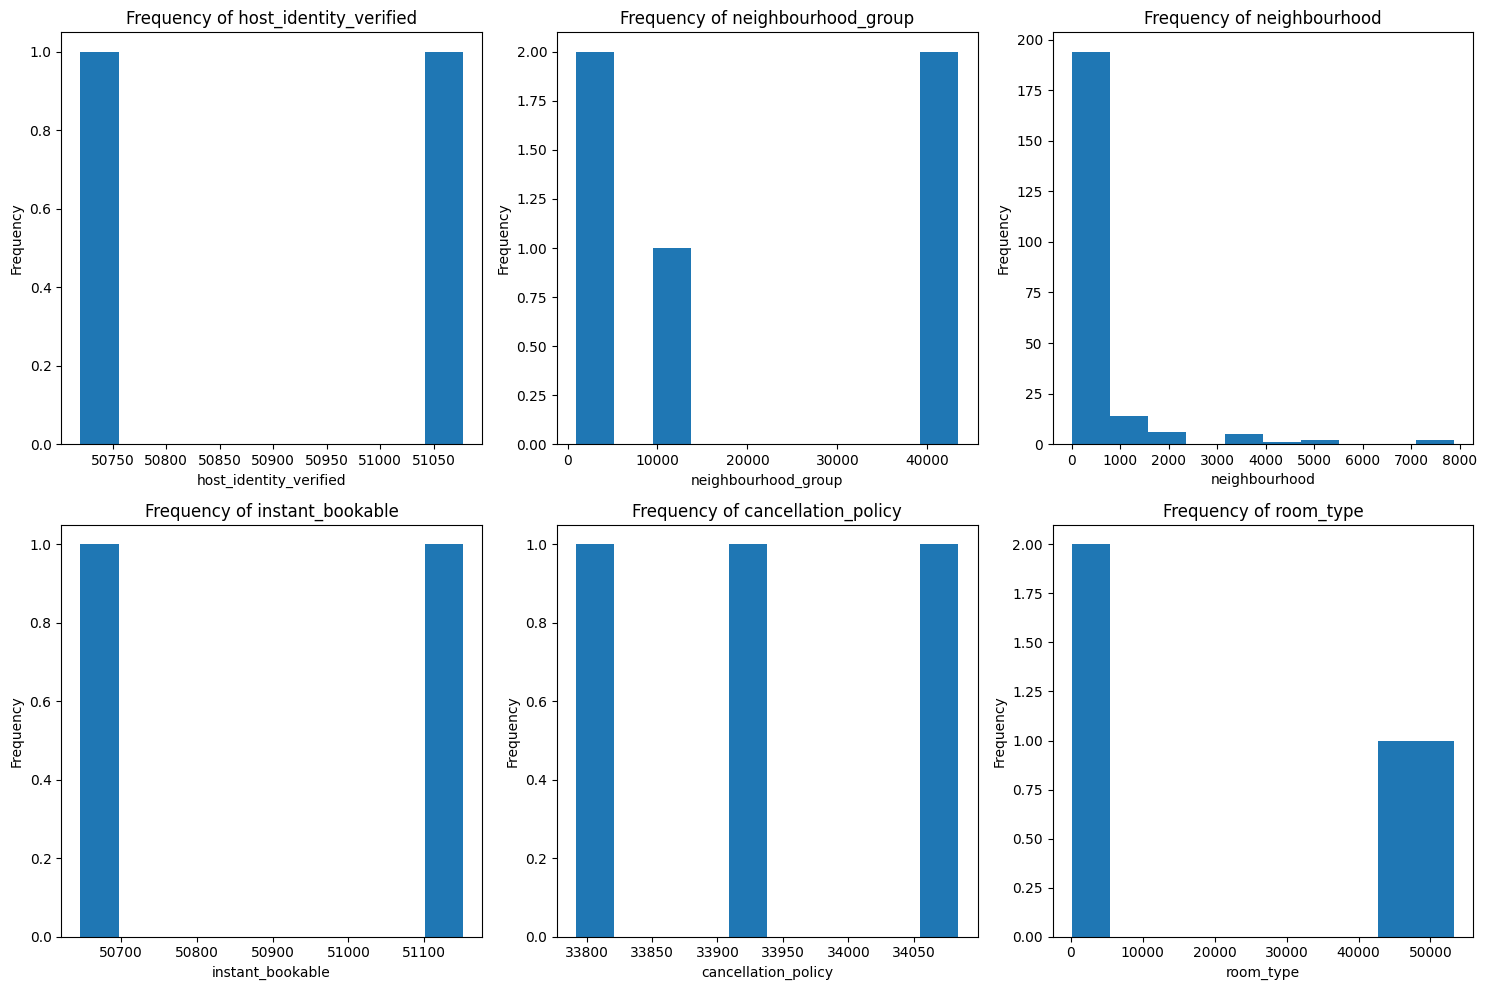

In [ ]:
# Generate frequency distributions dictionary
freq_distributions = generate_frequency_distributions(df, include_bool=True)
# Histogram plot
plot_frequency_grid(freq_distributions, cols_per_row=3, chart_type='hist')

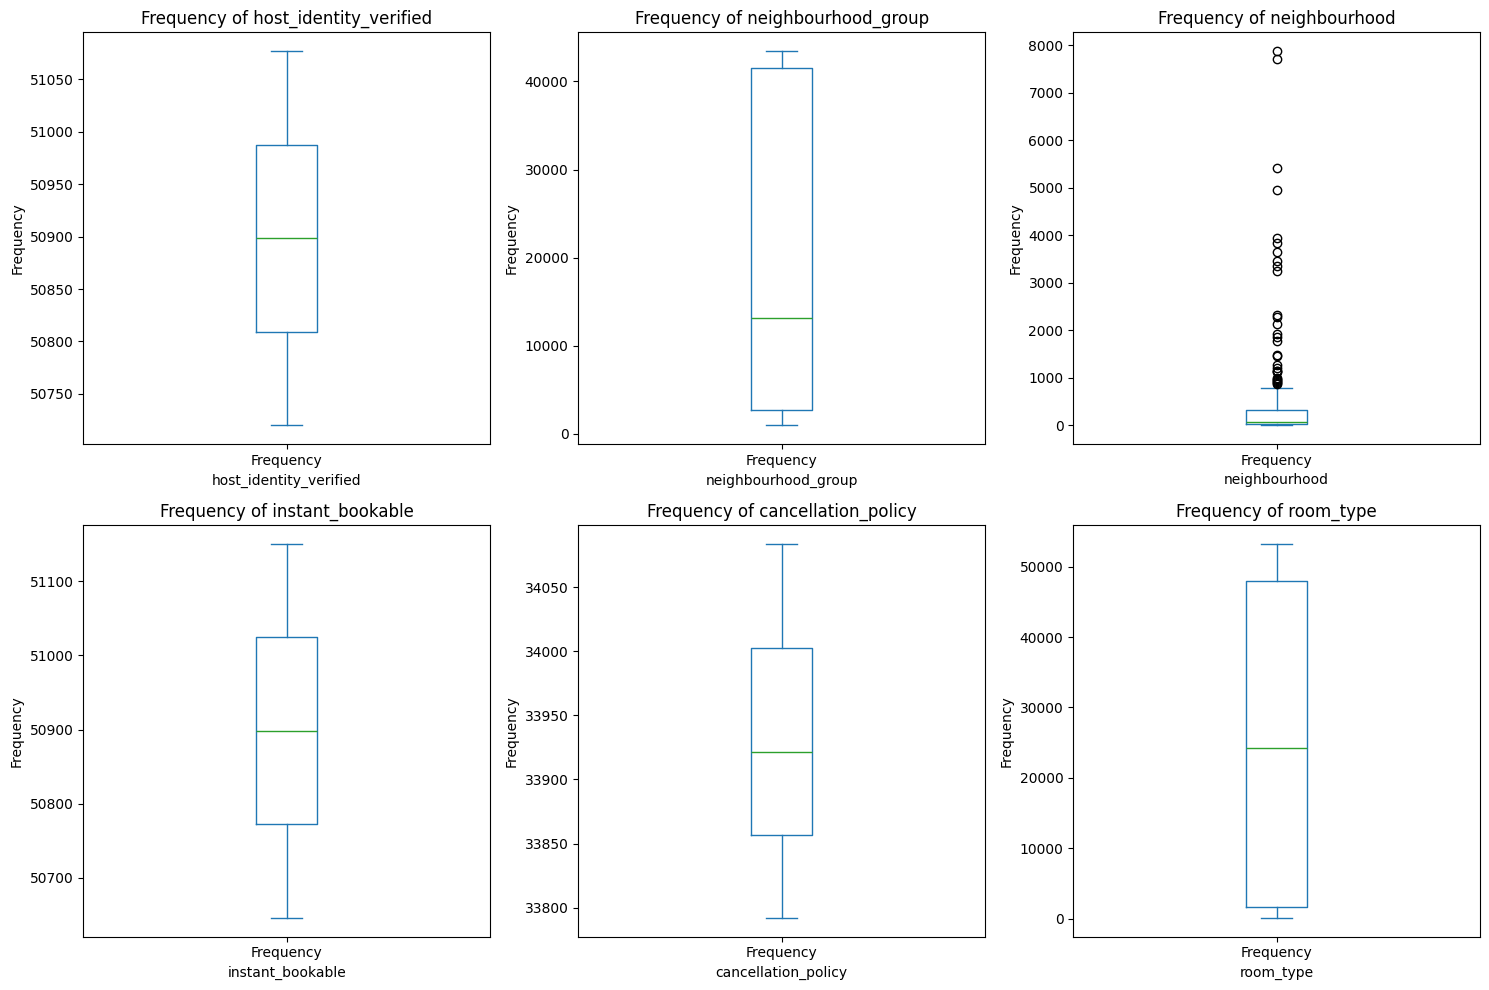

In [ ]:
# Box plot
plot_frequency_grid(freq_distributions, cols_per_row=3, chart_type='box')

*   Segment the data by relevant categories (e.g., by group, region) to identify trends.
  - Analyze average price of each *neighbourhood_group*

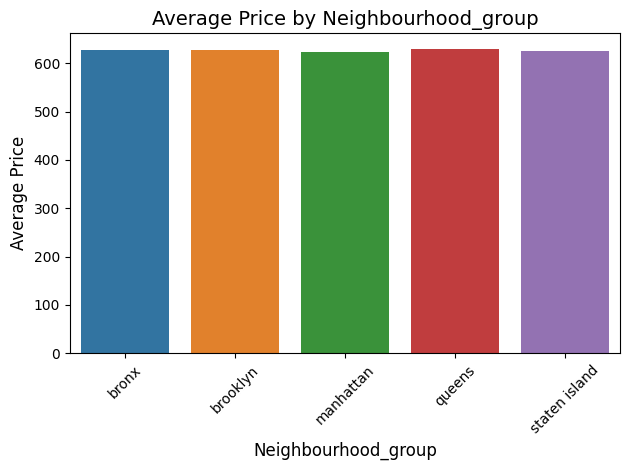

,neighbourhood_group,Average Price,Median Price,Price Std Dev
0,bronx,628.011712,633.000000,323.398928
1,brooklyn,626.484722,626.000000,331.590650
2,manhattan,622.672623,622.000000,330.878668
3,queens,630.405520,628.793220,333.669537
4,staten island,624.490078,628.000000,325.214375


In [ ]:
# Analyze the relationship between price and neighbourhood_group by diagram and table
group_price_analysis(df, 'neighbourhood_group')

**Analysis Results:**
1. **Highest Average Price:**
   - **Queens** has the highest average price at **$630.405520** per night.
   - This suggests that **Queens** might have more expensive listings or services.

2. **Lowest Average Price:**
   - **Staten Island** has the lowest average price at **$624.490078** per night.
   - This may indicate that **Staten Island** offers more budget-friendly options.

3. **Other Areas:**
   - **Bronx**: Average price is **628.011712**, relatively higher than most areas.
   - **Brooklyn**: Average price is **626.484722**, similar to **Bronx**.
   - **Manhattan**: Average price is **622.676223**, lower than most areas but slightly above **Staten Island**.

**Trend Summary:**
1. The average prices across the groups are relatively close (within a range of 6–8 units), showing no extreme outliers in pricing.
2. **Queens** has a slightly higher average price, potentially due to more high-end listings in the area.
3. **Staten Island** stands out as having the lowest average price, which may reflect lower demand or more affordable housing options.

*   Segment the data by relevant categories (e.g., by group, region) to identify trends.
  - Analyze average price of each *neighbourhood_group* and *construction_year_group*

<Figure size 640x480 with 0 Axes>

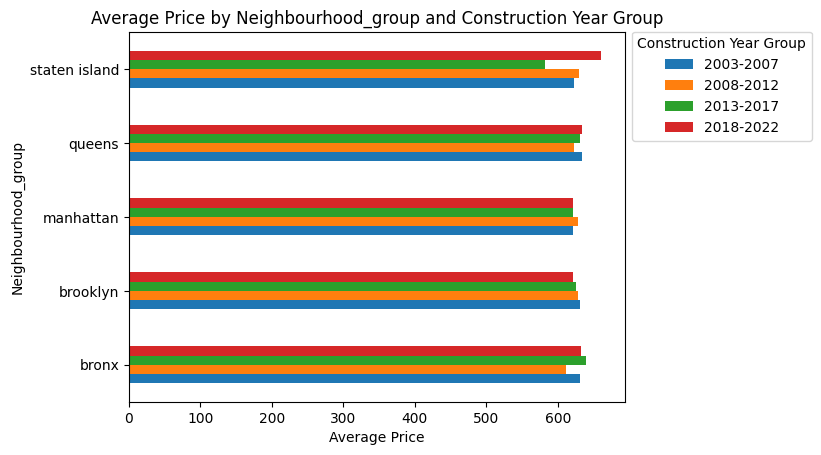

construction_year_group,2003-2007,2008-2012,2013-2017,2018-2022
neighbourhood_group,,,,
bronx,630.347926,610.705060,638.916783,632.278833
brooklyn,631.057711,628.391976,625.702936,620.831991
manhattan,621.064603,628.143853,620.634436,620.789619
queens,633.214517,622.866328,630.959688,634.446499
staten island,622.650682,629.072000,582.381910,660.743687


In [ ]:
# Analyze the relationship between price and neighbourhood_group and building age by diagram and table
group_year_price_analysis(df, 'neighbourhood_group')

**Analysis Result:**
1. **Bronx:**
   - Prices increase over time, peaking in the latest `2018–2022` group (**$632.27**).
   - Indicates newer constructions in the Bronx may be driving prices up.

2. **Brooklyn:**
   - Prices steadily rise across the years, with the highest in the `2018–2022` group (**$632.83**).
   - Suggests Brooklyn maintains consistent demand for newer constructions.

3. **Manhattan:**
   - Prices stay relatively stable across all years, with minor variation.
   - Reflects a mature and highly competitive market, with little dependency on construction year.

4. **Queens:**
   - Steady increase in prices, peaking in the latest `2018–2022` group (**$634.44**).
   - Queens has the highest average price for newer constructions among all groups.

5. **Staten Island:**
   - Prices show a slight decline in the `2013–2017` group but recover strongly in the `2018–2022` group (**$664.74**).
   - Highlights fluctuating demand but high value for the newest constructions.

**Trend Summary:**
1. **General Trend:**
   - Most neighborhoods show increasing prices for newer construction years, indicating higher market value for recent builds.
   - The exception is Manhattan, where prices remain consistent, showing less influence of construction year on value.

2. **Highest Demand for New Constructions:**
   - Staten Island leads with the highest prices in the `2018–2022` group, suggesting increased interest or limited supply of newer listings there.

3. **Price Stability:**
   - Manhattan’s consistency highlights a saturated or well-established market where construction year matters less.

*   Segment the data by relevant categories (e.g., by group, region) to identify trends.
  - Analyze average price of each *room_type*

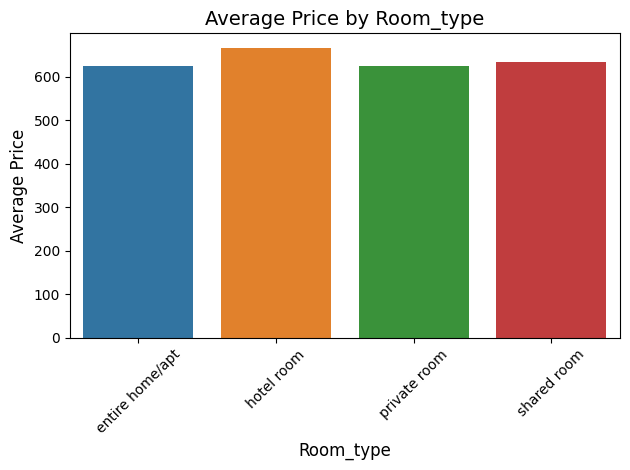

,room_type,Average Price,Median Price,Price Std Dev
0,entire home/apt,625.232564,624.210796,331.290203
1,hotel room,666.391304,643.000000,311.419689
2,private room,625.016092,623.000000,331.011432
3,shared room,634.729245,651.000000,337.930443


In [ ]:
# Analyze the relationship between price and room_type by diagram and table
group_price_analysis(df, 'room_type')

From the chart and table, we can observe some key insights regarding the relationship between **room types** and **average prices**:

1. **Overview of Price Distribution**:
   - The highest average price is for **hotel rooms**, at approximately 666.
   - This is followed by **shared rooms**, with an average price of 634.
   - **Entire home/apt** and **private rooms** come next, both averaging around 625.

2. **Price Volatility**:
   - The standard deviation values indicate similar levels of price variability across all room types.
   - However, **hotel rooms** exhibit slightly less price fluctuation (standard deviation of 311), suggesting more stable pricing.
   - **Shared rooms** show the highest variability (standard deviation of 338), indicating prices might be more influenced by external factors.

# **Diagnostic Analytics**


*   Perform correlation analysis to assess relationships between numerical variables.
*   Use cross-tabulation to examine relationships between categorical variables.
*   Conduct regression analysis to investigate dependencies between variables.
*   Perform statistical testing to determine significant factors.
*   Explain the findings and provide insights into why certain trends or relationships exist.

In [ ]:
# Load the data
df_da = df.copy()
df_da.drop(["construction_year_group"], axis=1, inplace=True)
df_da.head(3)

,id,host_identity_verified,neighbourhood_group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,review_rate_number,availability_365
0,1001254,unconfirmed,brooklyn,kensington,40.647490,-73.972370,False,strict,private room,2020,966.000000,193.000000,10,9,4,286
1,1002102,verified,manhattan,midtown,40.753620,-73.983770,False,moderate,entire home/apt,2007,142.000000,28.000000,30,45,4,228
2,1002403,unconfirmed,manhattan,harlem,40.809020,-73.941900,True,flexible,private room,2005,620.000000,124.000000,3,0,5,352



=== Pearson Correlation Matrix ===
                       price  service_fee  minimum_nights  number_of_reviews  \
price               1.000000     0.992675       -0.002643           0.005445   
service_fee         0.992675     1.000000       -0.003624           0.005660   
minimum_nights     -0.002643    -0.003624        1.000000          -0.050604   
number_of_reviews   0.005445     0.005660       -0.050604           1.000000   
review_rate_number -0.003987    -0.003966       -0.002354          -0.020363   
availability_365   -0.003068    -0.003482        0.059683           0.097558   

                    review_rate_number  availability_365  
price                        -0.003987         -0.003068  
service_fee                  -0.003966         -0.003482  
minimum_nights               -0.002354          0.059683  
number_of_reviews            -0.020363          0.097558  
review_rate_number            1.000000         -0.007025  
availability_365             -0.007025          1

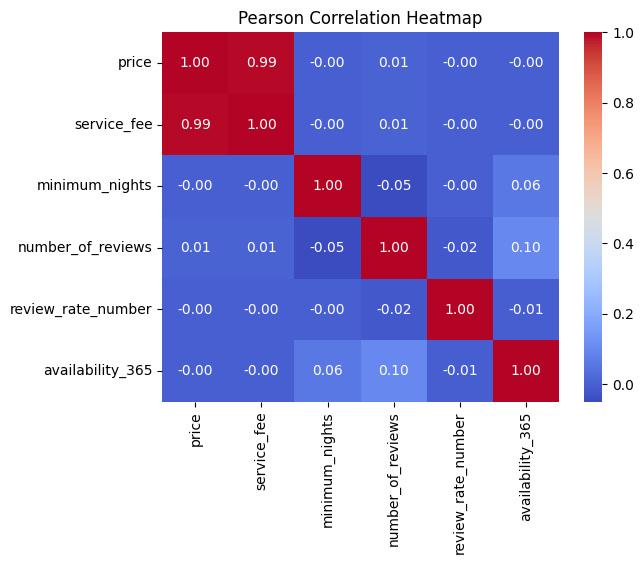

In [ ]:
# Calculation of the correlation between the variables by means of the Pearson or Spearman procedure.
numerical_columns = ['price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'review_rate_number', 'availability_365']
correlation_matrix = correlation_analysis(df_da, numerical_columns, method='pearson')

**Correlation Analysis Summary:**

1. **Strong Positive Correlation**:
   - *price* and *service_fee* show a very high correlation coefficient (**0.99**), indicating a strong positive linear relationship.

2. **Weak or No Correlation**:
   - *price* shows near-zero correlation with other variables such as *minimum_nights*, *number_of_reviews*, *review_rate_number*, and *availability_365*, implying almost no linear relationship.

**Summary:**
- **Key Drivers**: *price* and *service_fee* are tightly linked and can be used in predictive models.
- **Independence**: Other variables have weak or no linear relationship with *price*, which may require non-linear analysis or additional contextual features for further insights.
- **Data Structure**: The variables generally show low correlation, indicating high independence among them.

**Recommendations**:
- Investigate the highly-correlated relationship between *price* and *service_fee* further.
- Explore non-linear models
- Introduce new or derived variables and analyze their correlation to *price*.


Cross-Tabulation between 'neighbourhood_group' and 'room_type':


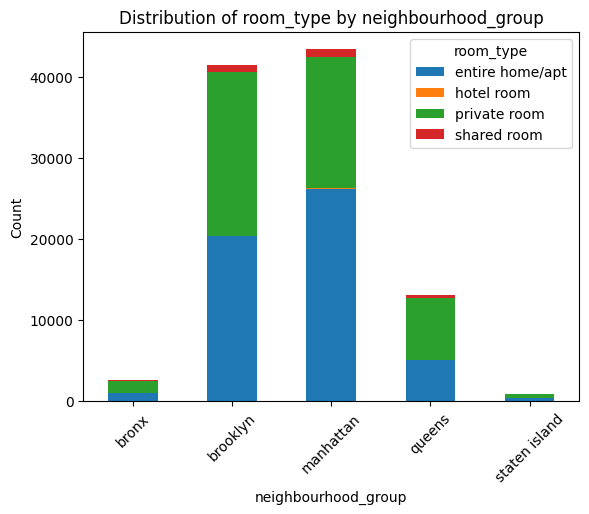

room_type,entire home/apt,hotel room,private room,shared room
neighbourhood_group,,,,
bronx,1020,0,1556,115
brooklyn,20416,7,20277,824
manhattan,26267,100,16195,894
queens,5110,8,7701,359
staten island,473,0,460,15


In [ ]:
# Cross-table of two categorical determinant variables
cross_tab_analysis(df_da, 'neighbourhood_group', 'room_type')

**Analysis of Room Type Distribution by Neighborhood Group:**

1. **Manhattan and Brooklyn Dominate**:
   - The majority of listings are concentrated in **Manhattan** and **Brooklyn**, with Manhattan having slightly more listings for 'entire home/apt' and 'private room' compared to Brooklyn.

2. **Popular Room Types**:
   - **Entire Home/Apt**:
     - Most common in Manhattan (26,267 listings) and Brooklyn (20,416 listings).
   - **Private Room**:
     - Second most common, with a significant presence in both Manhattan (16,195 listings) and Brooklyn (20,277 listings).
   - **Shared Room** and **Hotel Room**:
     - These are much less common across all neighborhoods.

3. **Neighborhood Insights**:
   - **Queens**:
     - Primarily offers private rooms (7,701 listings) and entire homes/apartments (5,110 listings).
   - **Staten Island**:
     - Represents a very small portion of listings, with 'private rooms' being the most common (460 listings).
   - **Bronx**:
     - Predominantly offers private rooms (1,556 listings), with smaller numbers of entire homes/apartments (1,020 listings).

**Summary:**
- Manhattan and Brooklyn are key hubs for both entire homes/apartments and private rooms.
- Shared and hotel rooms are niche categories across all neighborhoods, with very low representation.
- Staten Island and Bronx have significantly fewer listings, showing they are less prominent in the market.


Cross-Tabulation between 'neighbourhood_group' and 'cancellation_policy':


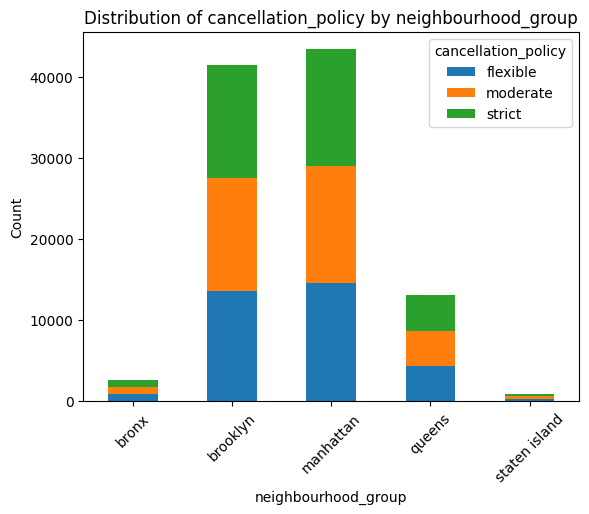

cancellation_policy,flexible,moderate,strict
neighbourhood_group,,,
bronx,908,894,889
brooklyn,13672,13926,13926
manhattan,14597,14505,14354
queens,4311,4422,4445
staten island,304,337,307


In [ ]:
cross_tab_analysis(df_da, 'neighbourhood_group', 'cancellation_policy')

**Analysis of Cancellation Policy Distribution by Neighborhood Group:**

1. **Flexible, Moderate, and Strict Policies are Well-Distributed**:
   - The distribution of 'flexible', 'moderate', and 'strict' cancellation policies is nearly uniform across all neighborhoods.

2. **Manhattan and Brooklyn Dominate Listings**:
   - **Brooklyn**:
     - Has a balanced number of listings for all policies, with around 13,672 (flexible), 13,926 (moderate), and 13,926 (strict).
   - **Manhattan**:
     - Shows a similar balance, with 14,597 (flexible), 14,505 (moderate), and 14,354 (strict).

3. **Other Neighborhoods Have Smaller Numbers**:
   - **Queens**:
     - Follows the same proportional trend but with fewer listings: 4,311 (flexible), 4,422 (moderate), and 4,445 (strict).
   - **Bronx**:
     - Minimal listings, around 900 for each policy type.
   - **Staten Island**:
     - The least representation with only ~300 listings per policy type.

4. **Insights by Neighborhood Group**:
   - Manhattan and Brooklyn dominate the market with all three policies equally popular.
   - Queens, Bronx, and Staten Island represent only a small fraction of listings, following a similar proportional trend.

In [ ]:
# Conducts linear regression analysis with the aim of discovering the link between independent factors and the dependent variable being studied.
independent_vars = ['service_fee', 'minimum_nights', 'availability_365']
dependent_var = 'price'
model = regression_analysis(df_da, independent_vars, dependent_var)


Regression Coefficients:
service_fee: 4.9417
minimum_nights: 0.0102
availability_365: 0.0008
Intercept: 8.8728


**Interpretation of Linear Regression Results:**

1. **Regression Coefficients**:
   - ***service_fee* (4.9417)**:
     - For every unit increase in the *service_fee*, the price increases by approximately **4.94** units, holding other variables constant.
     - This indicates that *service_fee* is a strong predictor of *price*.
   - ***minimum_nights* (0.0102)**:
     - A marginal impact—every additional night increases the price by **0.01** units, suggesting this factor has a minimal influence.
   - ***availability_365* (0.0008)**:
     - A very small positive relationship, with each additional available day increasing the price by **0.0008** units. This indicates availability is not a significant driver of price.

2. **Intercept (8.8728)**:
   - The baseline `price` when all independent variables are zero is **8.87**. This represents the starting point for the price in the absence of other factors.

**Key Observations:**
- ***service_fee*** is the most influential factor in determining price, with the largest coefficient.
- ***minimum_nights*** and ***availability_365*** have negligible impacts on price, implying they are less critical predictors in this model.
- There may be other significant factors influencing price that were not included in this dataset.

# **Predictive Analytics**


*   Select key variables to include into the predictive models.
*   Split the data into the training set and testing set for model training and evaluation.
*   Build and train 3+ different predictive models.
*   Test the models' accuracies and evaluate their performance.
*   Interpret and explain the predictions and their real-world applications (i.e. within the report)

In [ ]:
# Load the data
df_pa = df.copy()
df_pa.drop(["construction_year_group"], axis=1, inplace=True)
df_pa.head(3)

,id,host_identity_verified,neighbourhood_group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,review_rate_number,availability_365
0,1001254,unconfirmed,brooklyn,kensington,40.647490,-73.972370,False,strict,private room,2020,966.000000,193.000000,10,9,4,286
1,1002102,verified,manhattan,midtown,40.753620,-73.983770,False,moderate,entire home/apt,2007,142.000000,28.000000,30,45,4,228
2,1002403,unconfirmed,manhattan,harlem,40.809020,-73.941900,True,flexible,private room,2005,620.000000,124.000000,3,0,5,352


In [ ]:
# get all available models
models = get_models()

# create a Dataset using the loaded data
dataset = Dataset(
  dataFrame=df_pa,
  target="price",
  features=[
    "host_identity_verified",
    "neighbourhood_group",
    "neighbourhood",
    "instant_bookable",
    "cancellation_policy",
    "room_type",
    "service_fee",
    "minimum_nights",
    "number_of_reviews",
    "review_rate_number",
  ],
  scale_features=[
    "neighbourhood",
    "minimum_nights",
    "number_of_reviews",
  ],
  categorical_features=[
    "host_identity_verified",
    "neighbourhood_group",
    "neighbourhood",
    "instant_bookable",
    "cancellation_policy",
    "room_type",
  ],
)

# train the models using the created Dataset
evaluation = train_models(models, dataset)

# show evaluation of the models
evaluation.head(10)

Epoch 1/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 13258.2158 - mae: 28.6032
Epoch 2/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 525.6590 - mae: 5.6950
Epoch 3/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 592.2000 - mae: 6.2467
Epoch 4/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 568.1501 - mae: 5.8143
Epoch 5/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 612.5663 - mae: 6.0531
Epoch 6/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 514.0638 - mae: 5.4642
Epoch 7/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 508.7506 - mae: 5.8434
Epoch 8/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 423.3791 - mae: 4.7532
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,model,mean_squared_error,r_squared
0,Gradient Boosting Regressor,517.827976,0.995265
1,Linear Regression,1804.249763,0.983502
2,K-Nearest Neighbors Regressor,667.994935,0.993892
3,Decision Tree Regressor,1239.708566,0.988664
4,Neural Network,736.280657,0.993267


In [ ]:
# inquire the models
# > define questions
questions = pd.DataFrame({
  "host_identity_verified": ["unconfirmed", "unconfirmed"],
  "neighbourhood_group": ["manhattan", "manhattan"],
  "neighbourhood": ["east harlem", "harlem"],
  "instant_bookable": ["TRUE", "TRUE"],
  "cancellation_policy": ["moderate", "moderate"],
  "room_type": ["private room", "shared room"],
  "service_fee": [63, 33],
  "minimum_nights": [1, 1],
  "number_of_reviews": [33, 14],
  "review_rate_number": [4, 4],
})

# > inquire about questions
prediction = inquire(models, dataset, questions)

# show prediction of questions
prediction.head(10)

,price [Gradient Boosting Regressor],price [Linear Regression],price [K-Nearest Neighbors Regressor],price [Decision Tree Regressor],price [Neural Network]
0,313.389791,320.057997,314.600000,314.000000,316.193909
1,166.647863,171.692970,164.600000,163.000000,166.232910


In [ ]:
# show prediction of questions along-side the question itself
merge_by_index(questions, prediction).head(10)

,host_identity_verified,neighbourhood_group,neighbourhood,instant_bookable,cancellation_policy,room_type,service_fee,minimum_nights,number_of_reviews,review_rate_number,price [Gradient Boosting Regressor],price [Linear Regression],price [K-Nearest Neighbors Regressor],price [Decision Tree Regressor],price [Neural Network]
0,unconfirmed,manhattan,east harlem,TRUE,moderate,private room,63,1,33,4,313.389791,320.057997,314.600000,314.000000,316.193909
1,unconfirmed,manhattan,harlem,TRUE,moderate,shared room,33,1,14,4,166.647863,171.692970,164.600000,163.000000,166.232910


In [ ]:
# create another Dataset using the loaded data
# > using a different set of features
dataset_alt = Dataset(
  dataFrame=df_pa,
  target="price",
  categorical_features=[
    "host_identity_verified",
    "neighbourhood_group",
    "neighbourhood",
    "instant_bookable",
    "cancellation_policy",
    "room_type",
  ],
)

# re-train the models using the newly created Dataset
evaluations = train_models(models, dataset_alt)

# show evaluation of the models
evaluations.head(10)

Epoch 1/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 36314.2539 - mae: 79.8603
Epoch 2/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1681.9351 - mae: 13.1643
Epoch 3/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1583.1837 - mae: 11.7531
Epoch 4/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1449.7771 - mae: 10.3308
Epoch 5/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1335.4183 - mae: 9.7551
Epoch 6/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1305.8838 - mae: 9.4273
Epoch 7/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1543.2279 - mae: 10.0485
Epoch 8/8
2545/2545 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1536.8663 - mae: 10.6336
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,model,mean_squared_error,r_squared
0,Gradient Boosting Regressor,393.402960,0.996412
1,Linear Regression,1390.938713,0.987313
2,K-Nearest Neighbors Regressor,10295.837937,0.906089
3,Decision Tree Regressor,950.187118,0.991333
4,Neural Network,1168.133269,0.989345


Using these predictive models, Airbnb hosts can now price their listings accordingly and stay competitive in the market.